<a href="https://colab.research.google.com/github/jorellano/Crime-Sf/blob/master/Chtpt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [16]:
from fastbook import *
from fastai.vision.widgets import *

In [53]:
key = os.environ.get('AZURE_SEARCH_KEY', 'e63f4812a9ff413f9be72a59977bcf4c')

In [54]:
search_images_bing

<function fastbook.search_images_bing>

In [55]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contenturl')
len(ims)


150

In [56]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']



In [22]:
#create a directory where images is located
#import os
#os.mkdir('images')

In [57]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

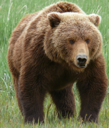

In [58]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [59]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')



In [60]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))
        


In [61]:
fns = get_image_files(path)
fns

(#402) [Path('bears/black/00000014.jpg'),Path('bears/black/00000020.jpg'),Path('bears/black/00000093.jpg'),Path('bears/black/00000007.jpg'),Path('bears/black/00000122.jpg'),Path('bears/black/00000005.jpg'),Path('bears/black/00000102.jpg'),Path('bears/black/00000017.jpg'),Path('bears/black/00000037.jpg'),Path('bears/black/00000137.jpg')...]

In [62]:
failed = verify_images(fns)
failed

(#0) []

In [63]:
failed.map(Path.unlink);


In [65]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

# From Data to DataLoaders

In [66]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])


In [67]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

#clean

In [68]:
key = os.environ.get('AZURE_SEARCH_KEY', 'e63f4812a9ff413f9be72a59977bcf4c')

In [69]:
dls = bears.dataloaders(path)

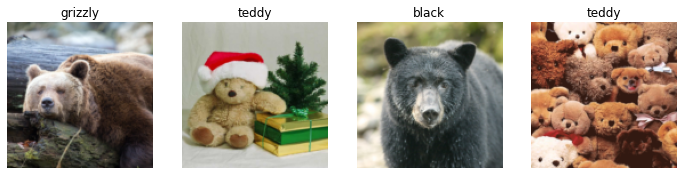

In [70]:
dls.valid.show_batch(max_n=4, nrows=1)

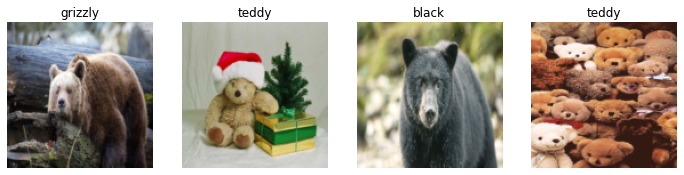

In [71]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

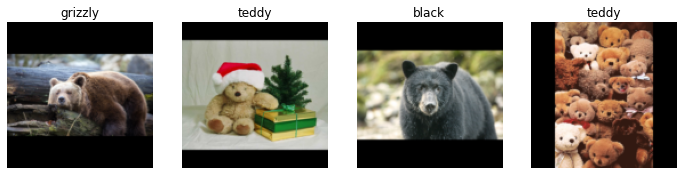

In [72]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros')
)
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

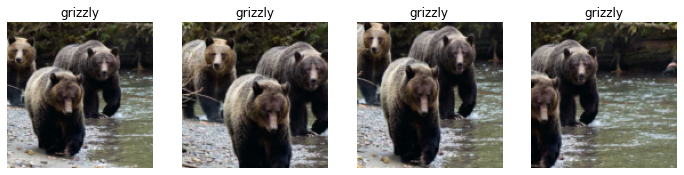

In [73]:
bears = bears.new(item_tfms=RandomResizedCrop(128,min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

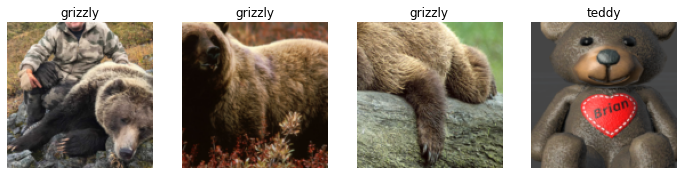

In [74]:
bears = bears.new(item_tfms=RandomResizedCrop(128,min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=False)

# Data Augmentation

1. Rotation
2. Flipping
3. Perspective warping
4. brightness change
5. contrast changes



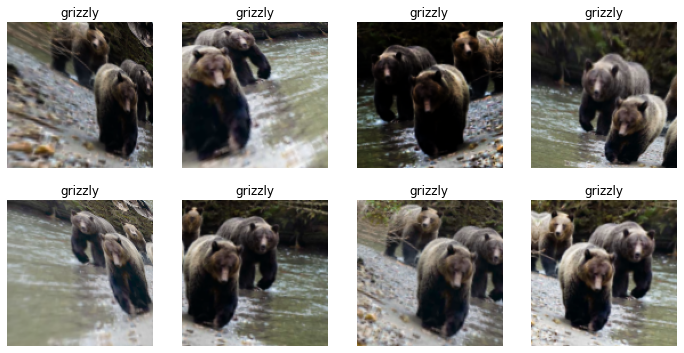

In [75]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Train model and use it to clean data

In [76]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [77]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

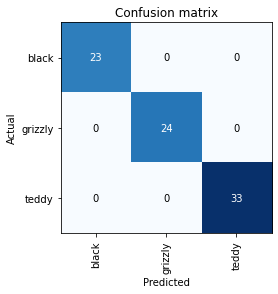

In [78]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


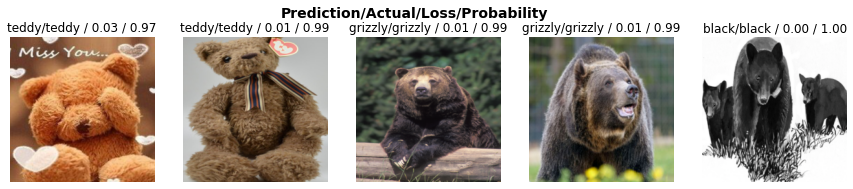

In [79]:
#2.6
interp.plot_top_losses(5, nrows=1)


In [80]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner


# Turning your model into an online application

In [81]:
learn.export()


In [82]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [83]:
learn_inf = load_learner(path/'export.pkl')
